<div id="container" style="position:relative;">
<div style="float:left"><h1> Content Recommendation System </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

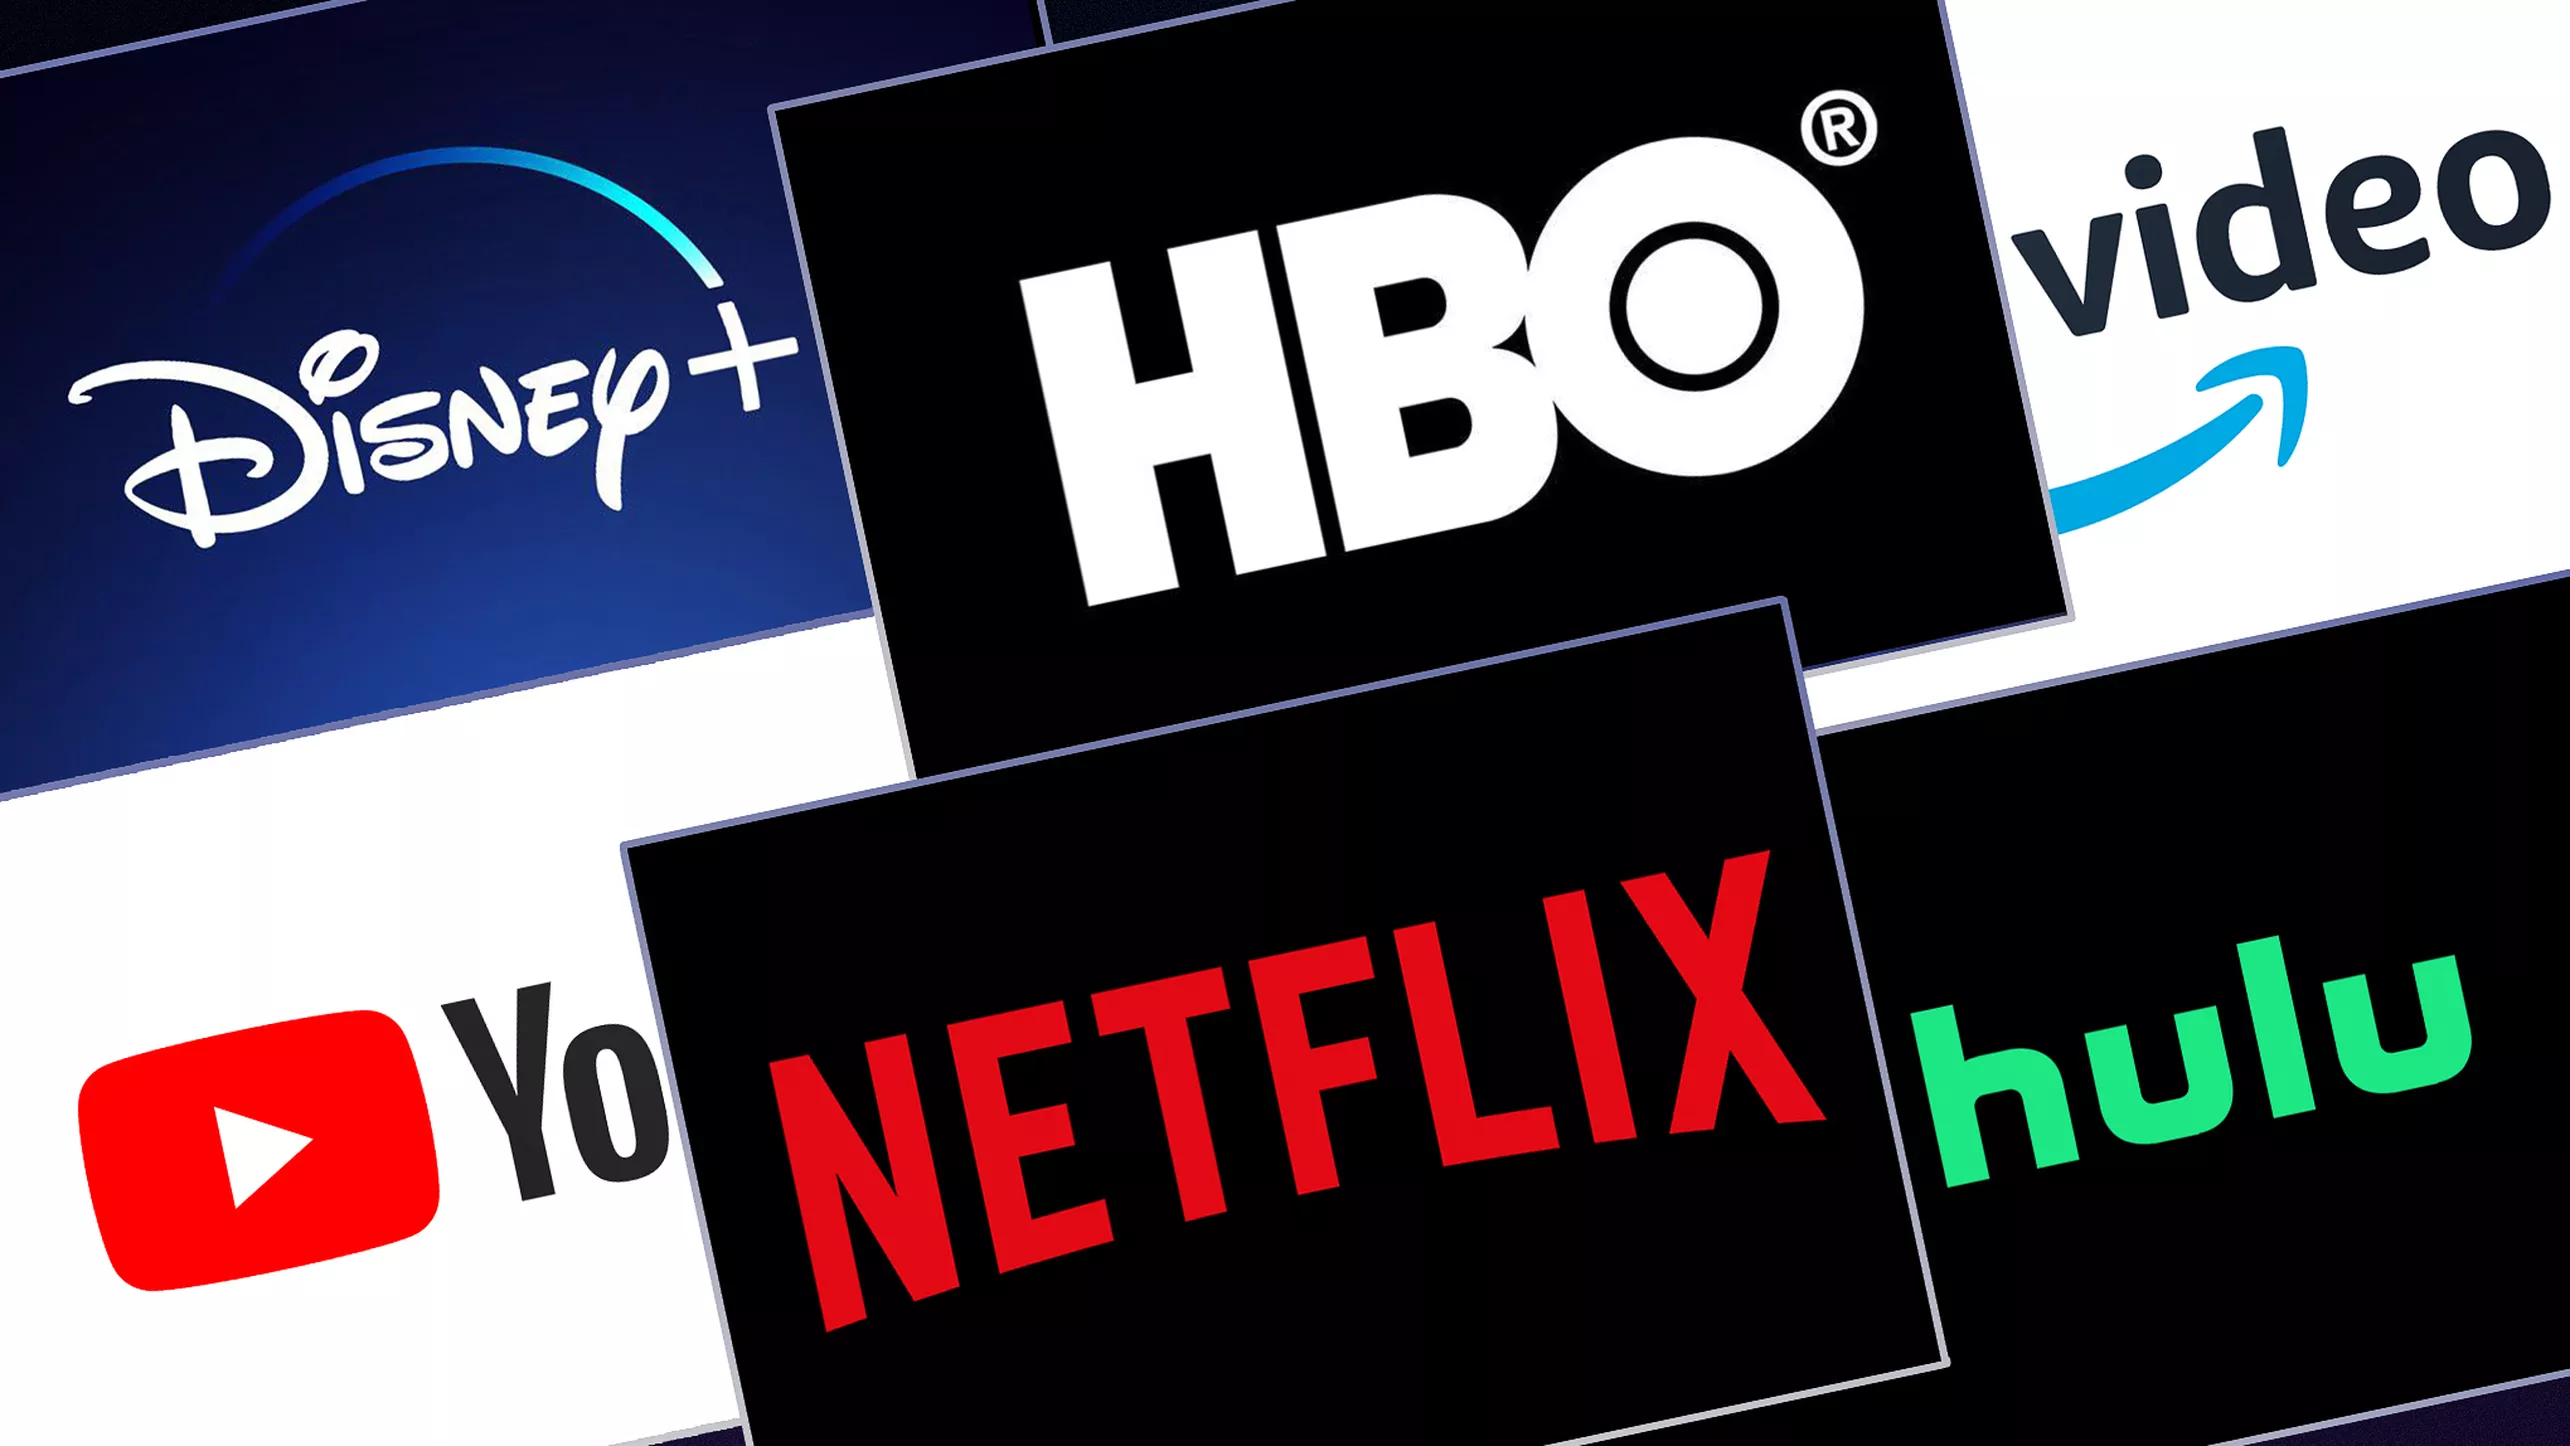

### **Table of Contents**
    
  - **Project Goal** 
  - **Data Acquisition** 
  - **Pre-Processing / Cleaning** 
  - **Exploration and Analysis** 
      - Movie Ratings (Part 1) 
      - Vote Count 
      - Movie Ratings (Part 2) 
      - Users 
  - **Modelling and Model Evaluation Overview** 
  - **Content Based Filtering** 
      - Overview
      - Building the Model
      - Content Based Recommendatoins for User 414
      - Model Evaluation 
  - **Collaborative Filtering (User-User)**
      - Overview 
      - Similarity Scores
          - Building the Simiarity Matrix
          - Investigating Similarity Scores
      - Building the Model
      - Model Evaluation 
      - Collaborative Filtering Recommendations (user-user) for User 414 
  - **Collaborative Filtering (Item-Item)** 
      - Overview 
      - Building the Model
      - Model Evaluation
      - Collaborative Filtering Recommendations (item-item) for User 414 
  - **Collaborative Filtering (SVD)**
      - Overview 
      - Building the Model
      - Model Evaluation 
      - SVD Based Recommendations for User 414  
  - **Conclusion**
  - **Next Steps**

# The Goal of This Project

The goal of this project is to build a model that's capable of predicting the ratings a user would give to a piece of content they have never seen before. In doing so we'll be able to develop an overall recommendation system that makes tailered recommendations to users of a given platform.

# Data Acquisition 

*Source:*

The dataset we will be using comes from MovieLens. 

Link: https://grouplens.org/datasets/movielens/latest/

In [626]:
#Import 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [627]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


**movieId:** Movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between movies_df and the following dataframe labeled ratings_df. (i.e., the same id refers to the same movie across the two data frames).

**titled:** Movie titles include the year of release in parentheses. Only movies with at least one rating are included in the dataset.

**genres:** Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [628]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Each line of this dataframe after the header row represents one rating of one movie by one user.

**UserId:** MovieLens users were selected at random for inclusion. Their ids have been anonymized. 

**MovieId:** Consistent with the one in the movie_df data frame

**Rating:** Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars) 

**Timestamp:** Represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

## Pre Processing/Cleaning

In [629]:
#Investigating if there are any nans in movies_df 
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [630]:
#Investigating if there are any nans in ratings_df
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [631]:
#Investigating if there are any duplicates in movies_df
#length of unique movie titles should be the same as the length of rows in the dataframe which we know is 9,742
len(movies_df['title'].unique())

9737

In [632]:
#This is a quick check to see if the movieIds are duplicated or if it just the title 
#If the values aren't equal then duplicated titles also have unique movieIds
len(movies_df['movieId'].unique())

9742

In [634]:
#We know we have 5 duplicated titles.
#Find duplicated titles 
duplicated_titles = movies_df[movies_df.duplicated(['title'])]
duplicated_titles

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [635]:
#before removing the duplicates and deleting their movieId  
#we will check if these duplicated movie titles have been given ratings

#Create a list of the movieIds that we will filter for 
duplicated_movie_list_movieId = duplicated_titles['movieId']

#Filter for movieIds in our list
ratings_for_duplicated_titles = ratings_df[ratings_df['movieId'].isin(duplicated_movie_list_movieId)]
ratings_for_duplicated_titles

,userId,movieId,rating,timestamp
4747,28,64997,3.5,1234850075
11451,68,64997,2.5,1230497715
17819,111,144606,4.0,1517441257
49832,318,147002,4.0,1502207152
80596,509,26958,3.5,1436031753
81458,514,168358,2.5,1533945970


In [636]:
#Change the movieId of these ratings to the movie id of the first instance of that title

#Get a list of all the duplicated titles 
duplicated_movie_list_titles = duplicated_titles['title']

#Create a dataframe that contains only the movie titles that are duplicated 
#We can then filter out the duplicate titles so that we can get the movie_ids of the first instance of the title
duplicated_movie_titles_df = movies_df[movies_df['title'].isin(duplicated_movie_list_titles)]

#Filter out the duplicates so that we're left with only the first instance of each duplicated title 
#along with its respective movieId 
movie_ids_to_assign_ratings_to = duplicated_movie_titles_df[~duplicated_movie_titles_df['movieId'].isin(duplicated_movie_list_movieId)]
movie_ids_to_assign_ratings_to

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller


In [633]:
#Taking a count of the unique movieIds ratings_df so that we can check this number 
#once we are done reassining the ratings to new Ids and confirm that it has worked
len(ratings_df['movieId'].unique())

9724

In [637]:
#So we have 6 ratings for 5 movies that we have to reassign 

#War of the Worls Movies 
ratings_df.at[4747, 'movieId'] = 34048
ratings_df.at[11451, 'movieId'] = 34048

#Confessions of a dangerous mind 
ratings_df.at[17819, 'movieId'] = 6003

#Eros
ratings_df.at[49832, 'movieId'] = 32600

#Emma
ratings_df.at[80596, 'movieId'] = 838

#Saturn3
ratings_df.at[81458, 'movieId'] = 2851

In [638]:
#Check to make sure that the movieIds for the duplicated titles are no longer there  
ratings_df[ratings_df['movieId'].isin(duplicated_movie_list_movieId)]

,userId,movieId,rating,timestamp


In [640]:
#The number of unique movieIds in the ratings_df 
#Should have decreased from that last time it was run by 6 (i.e. to 9,719)
len(ratings_df['movieId'].unique())

9719

In [641]:
#Now we can delete the duplicates rows from the movies_df

list_of_movieIds_to_delete = duplicated_titles['movieId']

for movieId in list_of_movieIds_to_delete:
    rows_to_delete = movies_df[movies_df['movieId'] == movieId].index
    movies_df.drop(rows_to_delete, inplace=True)

In [601]:
#Quick check to make sure the above cell worked
#The number of rows should now be 9,737 (i.e. 5 less than before)
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


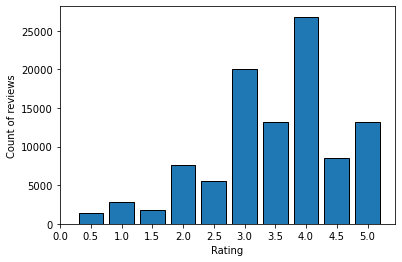

In [642]:
#Check the Distribution of Reviews
values, counts = np.unique(ratings_df['rating'], return_counts=True)
plt.figure()
plt.bar(values, counts, width = 0.4)
plt.xlabel('Rating')
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.ylabel('Count of reviews')
plt.show()

The above table is meant to check the distribution of the ratings just in case we need to make any adjustments. Reviews are almost normally distributed (they are slightly skewed) so we will leave them as is and move into exploration and analysis.

## Exploration and Analysis

In [648]:
#Before we start exploring let's get the movie titles and ratings together in one place 
titles_ratings_df = pd.merge(movies_df, ratings_df, on='movieId', how='left')
titles_ratings_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [649]:
#For exploration and modeling purposes, I will not be using the timestamp column, so we will just drop that column now 
titles_ratings_df.drop('timestamp', axis=1, inplace=True)
titles_ratings_df

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5
100851,193585,Flint (2017),Drama,184.0,3.5
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5


### Movie Ratings  (Part 1)
Let's start off by taking a look at which movies are the highest rated: 



In [650]:
#Creating a df containing average rating of movies
movie_stats = titles_ratings_df.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.columns = ['times_rated', 'average_rating']
movie_stats.head()

#Which movies are the most highly rated based on average rating: 
movie_stats.sort_values(by=['average_rating'],ascending=False).head(10)

,times_rated,average_rating
title,,
Gena the Crocodile (1969),1.0,5.0
True Stories (1986),1.0,5.0
Cosmic Scrat-tastrophe (2015),1.0,5.0
Love and Pigeons (1985),1.0,5.0
Red Sorghum (Hong gao liang) (1987),1.0,5.0
"Thin Line Between Love and Hate, A (1996)",1.0,5.0
Lesson Faust (1994),2.0,5.0
Eva (2011),1.0,5.0
Who Killed Chea Vichea? (2010),1.0,5.0


Two things stand out here. 

1. The highest rated movies are movies that we've likely never heard of before. 

2. They've all been rated just once! Let's take a look into how many times these movies have been rated before jumping back and investigating which movies are the most highly rated.  

### Vote Count

When doing things as complex as recommending movies or as simple as figuring out which movie is the most popular, we likely don't want to place too much weight on movies until they've reached a certain number of votes. Before we decide what this 'cutoff' number will be, let's figure out what the range of votes we have for our different titles is. 

In [651]:
#The25MostRatedMovies
number_of_times_rated = titles_ratings_df.title.value_counts().rename_axis('title').reset_index(name='times_rated')
number_of_times_rated.head(25)

,title,times_rated
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


In [652]:
#The25LeastRatedMovies
number_of_times_rated.tail(25)

,title,times_rated
9712,Broken English (1996),1
9713,Daddy Long Legs (1919),1
9714,"Mondays in the Sun (Lunes al sol, Los) (2002)",1
9715,Gentleman's Agreement (1947),1
9716,Double Trouble (1992),1
9717,San Francisco (1936),1
9718,China Blue (2005),1
9719,Assassination Tango (2002),1
9720,Bloodmoon (1997),1
9721,Dreamer: Inspired by a True Story (2005),1


In [653]:
#Let's get a better understanding of the distribution of our vote counts 
#How many movies have been rated a given number of times 
values, counts = np.unique(number_of_times_rated['times_rated'], return_counts=True)

value_counts_df = pd.DataFrame({'value':values, 'counts':counts})
value_counts_df

,value,counts
0,1,3459
1,2,1298
2,3,800
3,4,529
4,5,383
...,...,...
172,278,1
173,279,1
174,307,1
175,317,1


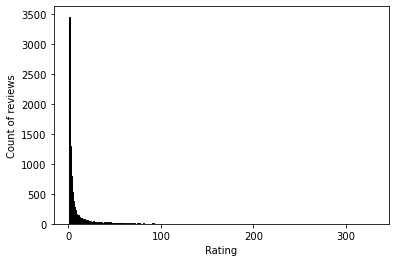

In [654]:
#Visualization of the above table 
values, counts = np.unique(number_of_times_rated['times_rated'], return_counts=True)
plt.figure()
plt.bar(values, counts, width = 1)
plt.xlabel('Rating')
plt.xticks(np.arange(0, 350, step=100))
plt.ylabel('Count of reviews')
plt.show()

In [779]:
#This will help us see the cumulative percentage of movies that we are discarding by setting up a cuttoff figure
value_counts_df['pct'] = value_counts_df.counts / value_counts_df.counts.sum()
value_counts_df['cumulative_percentage'] = value_counts_df['pct'].cumsum()
value_counts_df.head(20)

,value,counts,pct,cumulative_percentage
0,1,3459,0.355243,0.355243
1,2,1298,0.133306,0.488549
2,3,800,0.082161,0.570710
3,4,529,0.054329,0.625039
4,5,383,0.039334,0.664373
...,...,...,...,...
172,278,1,0.000103,0.999589
173,279,1,0.000103,0.999692
174,307,1,0.000103,0.999795
175,317,1,0.000103,0.999897


A staggering 57% of our titles have only been rated 3 times! Let's visualize this and see just how steep the slope for our cumulative percentage will be as we move along the x-axis. 

Text(0.5, 0, 'Number of Votes')

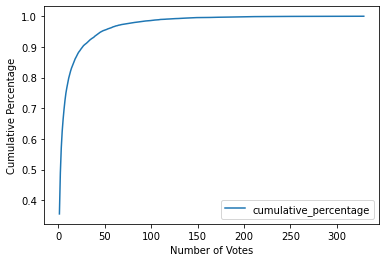

In [778]:
#Visualize the above table 
value_counts_df.plot(x="value", y=["cumulative_percentage"])
plt.ylabel('Cumulative Percentage')
plt.xlabel('Number of Votes')

We can now view the relationship between the number of times a movie has been rated and that movie's average rating:

<Figure size 576x432 with 0 Axes>

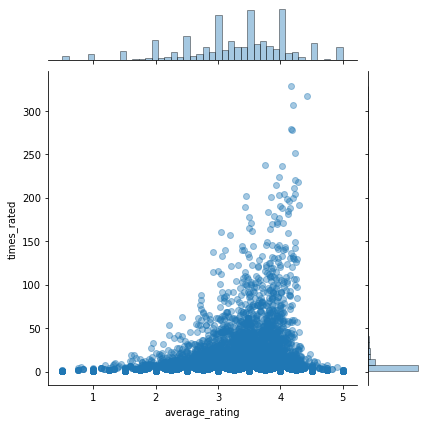

In [657]:
#Relationship between number of times a movie was reviewed and average rating 
import seaborn as sns
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='average_rating', y='times_rated', data=movie_stats, alpha=0.4)

Seems like movies that are either very highly or poorly rated tend to only have a handful of votes. Movies that have been rated often seem to fall between a rating of 3.0 to 4.0 

### Movie Ratings (Part 2)

With a better of understanding of how many times the titles in our data set have been rated we can now set an informed cut-off figure before deciding which movies are the highest rated

In [658]:
#Looking at highest rated again but now with a cutoff based on the number of votes
atleast_60_votes = movie_stats['times_rated'] >= 60
atleast_60_votes = movie_stats[atleast_60_votes].sort_values([('average_rating')], ascending=False)[:15]
atleast_60_votes

,times_rated,average_rating
title,,
"Shawshank Redemption, The (1994)",317.0,4.429022
"Godfather, The (1972)",192.0,4.289062
Fight Club (1999),218.0,4.272936
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),97.0,4.268041
Rear Window (1954),84.0,4.261905
"Godfather: Part II, The (1974)",129.0,4.259690
"Departed, The (2006)",107.0,4.252336
Goodfellas (1990),126.0,4.250000
Casablanca (1942),100.0,4.240000


### Users

One final thing we can look into before we jump into our modeling is our users. We can begin by answering the question: 'Which user rated the most movies, and how many movies did they rate?'

In [659]:
#Creating a dataframe with user, number of votes, and the average of those votes 
ratings_stats = titles_ratings_df.groupby('userId').agg({'rating': [np.size, np.mean]})
ratings_stats.columns = ['ratings_count', 'average_rating']
ratings_stats.head()

#Which user has rated the largest number of movies 
ratings_stats.sort_values(by=['ratings_count'],ascending=False).head(10)

,ratings_count,average_rating
userId,,
414.0,2698.0,3.391957
599.0,2478.0,2.642050
474.0,2108.0,3.398956
448.0,1864.0,2.847371
274.0,1346.0,3.235884
610.0,1302.0,3.688556
68.0,1260.0,3.233730
380.0,1218.0,3.673235
606.0,1115.0,3.657399


As a thank-you to user '414' for providing us with so much data, we'll be gifting them a list of recommendations at the end of this notebook.

Our next step is to figure out which users gives the highest/lowest rating on average:

In [660]:
#Which user gives the highest ratings based on average rating 
ratings_stats.sort_values(by=['average_rating'],ascending=False)

,ratings_count,average_rating
userId,,
53.0,20.0,5.000000
251.0,23.0,4.869565
515.0,26.0,4.846154
25.0,26.0,4.807692
30.0,34.0,4.735294
...,...,...
567.0,385.0,2.245455
153.0,179.0,2.217877
508.0,24.0,2.145833


User 53 has loved ever movie they've watched so far (or they just rate every movie a  '5' regardless of how they actually felt) while user 442 seems to be a much harsher critic.  

<Figure size 576x432 with 0 Axes>

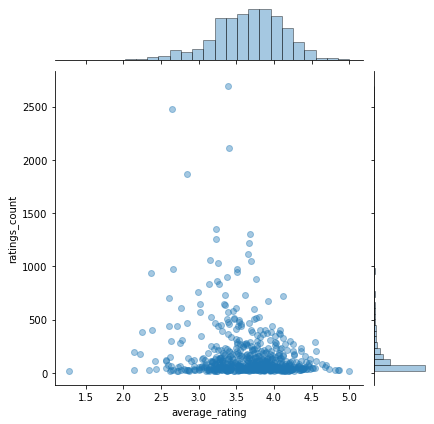

In [661]:
#Relationship between average rating of a user and the number of reviews by that user 

import seaborn as sns

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='average_rating', y='ratings_count', data=ratings_stats, alpha=0.4)

Just like the visual that showed us the relationship between the number of times a movie was rated and its average rating, we can see here that users who have an extremely high or low average rating tend to have rated realtively fewer movies. On the other hand, users that rated more movies seem to usually have an average rating between 3.0 to 4.0 

# Modeling and Model Evaluation 

The four different types of recommendation systems we will explore in this notebook are: 
1. Content-Based Filtering
2. Collaborative Filtering (user-user)
3. Collaborative Filtering (item-item)
4. Matrix Factorization using FunkSVD 

## Content Based Filtering

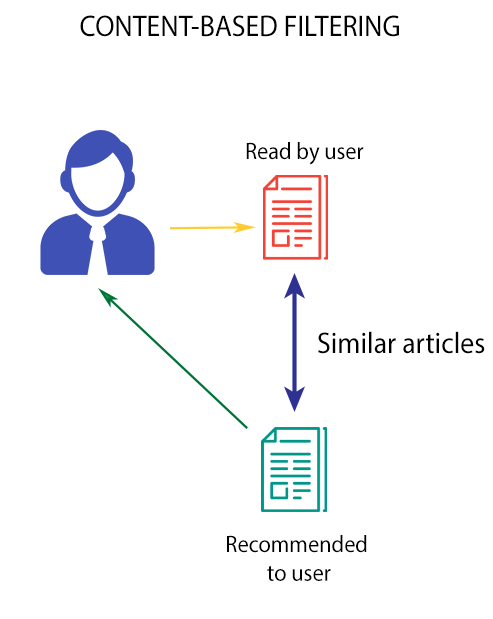

### Overview

**A quick overview of how this model works**: Content-Based filtering uses the features of a movie that a user liked to recommend other movies that have similar features. It is up to us to decide what these features are. In the case of movies, some obvious features include genre, actor, and director. Given that our dataset only includes information regarding genre, we'll use that as our key feature here. 

### The details:


**How recommendations are made:**

- In this model, each item is stored as a point of its features in an n-dimensional space. In our case the only feautre will be genre, and we'll use term freqeuncy/inverse document frequency to quantify this feature. 
- Within this space is a point that represents your taste in movies based on what you've watched 
- The angles between these points (your tastes vs other movies that are plotted around that point) are then calculated to determine the similarity between the vectors. 
- The points that are closest to the movie a user liked are the movies that will be reccomended 

**How we calculate how close two points are**:
The relative measure is calculated by taking the **cosine of the angle** between the features presented on the axis  and the features of the movie.

### Building the Content Based Filtering Model

In [769]:
#Function that allows us to look up a specific movie's TFIDF score by the movie's name
def get_movie_by_name(name, tfidf_scores, keys):
    row_id = keys[name] #Will assign the index of the movie to row_id
    row = tfidf_scores[row_id,:] #The tfidf score of that specific movie is assigned to the variable labeled 'row'
    return row #The tfidf score, which is still a matrix, is returned at the end of the function 

In [770]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Transforms words to TFIDF
vectorizer = TfidfVectorizer(stop_words = "english")

index = 0
keys = {} #Keys is a empty dictionary 


for movies in movies_df.itertuples() :
    key = movies[2] #The title of the movie is assigned to the 'key' of the dictionary. 
    keys[key] = index  #Each key (i.e. movie title) has a value equal to the index variable. That variables starts at 0. 
    index += 1 #index just increases by 1 in each loop 

#Fit the vectorizer to the data
vectorizer.fit(movies_df['genres'].fillna(''))

#Transform the data - applies our bag of words to the contents in the 'genre' column for each movie 
tfidf_scores = vectorizer.transform(movies_df['genres'].fillna(''))

In [771]:
from sklearn.metrics.pairwise import cosine_similarity

#This function will allow us to calculate the similarity scores between movies based on the contents of the genre column. 
#While there are several options for calculating similarity scores, we will use Cosine. 

def content_recommender(title, tfidf_scores, movies) :
    
    #Store the results in this DF - we only gave it two columns with a column titled 'title' and 'similarity'
    similar_movies = pd.DataFrame(columns = ["title","similarity"] )
    
    #The movie we are finding movies similar to
    movie_1 = get_movie_by_name(title, tfidf_scores, keys)
    
    #Go through ALL the movies
    for movie in movies['title'] :
                
        #Find the similarity of the two movies
        movie_2 = get_movie_by_name(movie,tfidf_scores,keys) #tfidf score of every movie with the movie you named in the function 
        similarity = cosine_similarity(movie_1,movie_2) #similarity between two scores 
        similar_movies.loc[len(similar_movies)] = [movie, similarity[0][0]] #inserts the following into a new row: #movie title and similarity score with the 0s removing the brackets 

    return similar_movies.sort_values(by=['similarity'],ascending=False)[1:] #This is now a data frame that is sorted

In [772]:
#Now we can start recommending movies based on titles 
#This is an example: 
similar_movies = content_recommender("Toy Story (1995)", tfidf_scores, movies_df)
similar_movies.head(20)

,title,similarity
6193,"Wild, The (2006)",1.000000
2809,"Adventures of Rocky and Bullwinkle, The (2000)",1.000000
2355,Toy Story 2 (1999),1.000000
8217,Turbo (2013),1.000000
9426,Moana (2016),1.000000
3000,"Emperor's New Groove, The (2000)",1.000000
7758,Asterix and the Vikings (Astérix et les Viking...,1.000000
6946,"Tale of Despereaux, The (2008)",1.000000
8925,The Good Dinosaur (2015),1.000000
3568,"Monsters, Inc. (2001)",1.000000


### Content-Based Recommendations for User 414 

As a thank-you to user 414 for all of their ratings, we'll dedicate this section to coming up with a top 10 list for them using content-based recommendations.

In [666]:
#Creating a df of the movies that user 414 has rated
top_recom_user14_content = ratings_df.loc[ratings_df['userId'] == 414].sort_values(by=['rating'],ascending=False).head(10)

#Adding the title of each movie to the df
#the user's highest rated movies seem to be pretty old 
top_recom_user14_content = top_recom_user14_content.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
top_recom_user14_content

,userId,movieId,rating,timestamp,title
0,414,1262,5.0,961512341,"Great Escape, The (1963)"
1,414,750,5.0,961512341,Dr. Strangelove or: How I Learned to Stop Worr...
2,414,4380,5.0,1016462828,"Princess and the Warrior, The (Krieger und die..."
3,414,953,5.0,1010675893,It's a Wonderful Life (1946)
4,414,924,5.0,961514698,2001: A Space Odyssey (1968)
5,414,923,5.0,961516613,Citizen Kane (1941)
6,414,916,5.0,961513654,Roman Holiday (1953)
7,414,2087,5.0,961519005,Peter Pan (1953)
8,414,912,5.0,961512311,Casablanca (1942)
9,414,910,5.0,961595311,Some Like It Hot (1959)


Based on the list of movies that we see above, it seems like user 414 has a preference for older movies. Let's see what our Content-Based system we'll recommend to this user based on "Casablanca" - a movie user 414 rated 5 stars!

Casablanca is a classic romantic movie, so we expect to see titles that imply similar themes. 

In [721]:
#Generating Top 10 Recommendations 
similar_movies = content_recommender("Casablanca (1942)", tfidf_scores, movies_df)
similar_movies.head(10)

,title,similarity
490,Germinal (1993),1.0
1263,"Joy Luck Club, The (1993)",1.0
6909,Fireproof (2008),1.0
1265,Sliding Doors (1998),1.0
3807,Rain (2001),1.0
1268,"Wings of the Dove, The (1997)",1.0
4986,Pride and Prejudice (1995),1.0
1269,Mrs. Dalloway (1997),1.0
1270,"I Love You, I Love You Not (1996)",1.0
6381,Venus (2006),1.0


Based on the titles above, it looks like our system worked the way we expected it to!

## Evaluating our Content Based Recommendation System

### Advantages
- **No cold-start or sparsity problems:** In coming up with recommendations for user 414, we didn't need any data about other users. 
- **Recommending niche items:** The model can capture the specific interests of a user based on the movies they like, and can then recommend niche items that very few other users are interested in. 
- **Transparency behind the decision making:** Can provide explanations for recommended items by listing content-features that caused an item to be recommended.

### Disadvantages
- **Must be able to select the right features:** In this case, it was easy for us to select features because we only had one to work with. But what we be the correct number of features to include if we decided to import more information? For instance, we could include other features like movie descriptions, actors, directors, etc. for each title.   The point is that since the feature we are including are hand-picked by us, this model requires a lot of domain knowledge to ensure that you're picking the right features. And since the model bases its recommendations based on the features we choose, the model can only be as good as the hand-engineered features.

- **No new interests:** The model can only make recommendations based on existing interests of the user. Some users might find themselves bored if they're always recommended the same type of content on a streaming platform.

- **Juding how well the model worked:** With models that allow you to calculate metrics like RMSE, it can be easy to compare how accurate one model was vs. another. In this case, we don't really have a metric to work off of. This isn't ideal because if we built models using different features who is to say that which model is the superior one.

## Collaborative Filtering

The next types of recommendations system we will investigate are all variations of collaborative filtering.

### Collaborative Filtering (user-user)

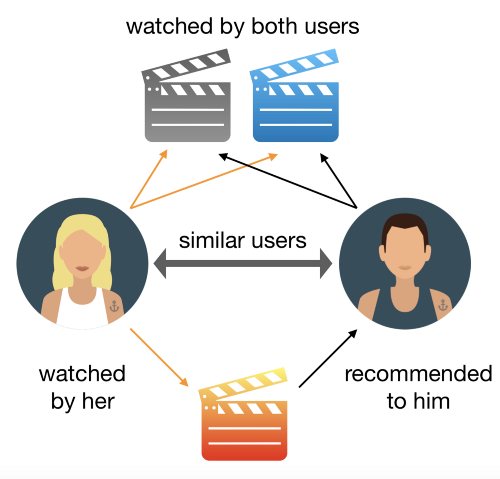

Here we'll find look alike users based on a similarity score and then recommend movies based on the scores that similar users have given other movies. 

We start off by building a similarity matrix. For user-user collaborative filtering, the similarity matrix will consist of the similarity scores between users (measured once again using cosine). 

We will then start to predict the ratings a given user would give a movie they haven't seen based on a combination of their similarity scores with other users and the rating those users assigned other movies. 

The exact formula we use to predict a rating for user $u$ and movie $i$ using the rating given by other users $R$ to the movie in question:

$$\hat{R_{um}} = \frac{\sum_{v=1}^C R_{vm} \cdot \text{user_similarity}(u, v)}{\sum_{v=1}^C \text{user_similarity}(u, v)}$$

### Creating a similarity matrix 

We start off by building a similarity matrix for all users 

In [668]:
#Ratings are stored within this matrix 
user_title_matrix = titles_ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
user_title_matrix 

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608.0,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [669]:
# Creating an empty matrix that we can place the similarity scores between users within 
similarity_matrix_user_user = pd.DataFrame(index=range(1, 611), columns=range(1, 611))
similarity_matrix_user_user

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [670]:
#Function that is meant to get the similarity scores between users 

def find_user_similarity(user_1, user_2, user_title_matrix):
    
    #How it works: 
    #Will return rows of true/false for each movie based on if rated by the user or not
    #(i.e. if there is a nan value or not)
    #We use the tilde sign '~' to get the opposite. So if the value is nan we get a true. 
    #But that means the user hasn't watched the movie so we reverse it into a false. 
    movies_1st_user_rated = ~user_title_matrix.loc[user_1, :].isna()
    movies_2nd_user_rated = ~user_title_matrix.loc[user_2, :].isna()
    
    #will give a true in the row if that movie was watched by both users, otherwise false 
    #(i.e. There was a true in that movie's row for each user)
    movies_both_users_rated = movies_1st_user_rated & movies_2nd_user_rated

    #Will sum up all the trues
    #The sum will represent the number of movies that were reviewed by both users
    number_of_movies_rated_together = movies_both_users_rated.sum()
    
    #If two users haven't rated the same movies we can't calculate a similarity score 
    #so we return a -1 to signify that 
    if number_of_movies_rated_together == 0:
        return -1 
        
    #Find the ratings each user gave the movies they both watched
    #Returns an array of each user's score, for only the movies watched by both users 
    ratings_of_user1 = user_title_matrix.loc[user_1, movies_both_users_rated].values.reshape(1, -1)
    ratings_of_user2 = user_title_matrix.loc[user_2, movies_both_users_rated].values.reshape(1, -1)
    
    # Finally, calculate the similarity between them based on the scores they gave the movies they both watched 
    similarity = cosine_similarity(ratings_of_user1, ratings_of_user2)[0][0]
    
    return similarity

In [671]:
#Calculating the scores and storing them in the matrix
for i in user_title_matrix .index:
    for j in user_title_matrix .index:
        similarity = find_user_similarity(i, j, user_title_matrix)
                                                                          
        # If similarity is -1, users have not rated the same movie, so skip
        if similarity == -1: 
            continue
    
        similarity_matrix_user_user[i][j] = similarity

similarity_matrix_user_user

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,1,1,0.791903,0.93281,0.97077,0.939243,0.951037,0.978123,0.995739,0.758089,...,0.992413,0.95883,0.92749,0.954033,0.937549,0.967379,0.958247,0.956573,0.977068,0.976881
2,1,1,NaN,1,1,0.989949,0.798522,1,NaN,0.839054,...,0.981042,1,0.979937,NaN,NaN,0.993528,1,0.990077,1,0.990501
3,0.791903,NaN,1,1,1,0.990148,NaN,1,NaN,NaN,...,0.993884,0.970143,0.699694,NaN,1,0.470979,0.560226,0.611787,NaN,0.860294
4,0.93281,1,1,1,0.901137,0.899828,0.945977,0.879079,1,0.847416,...,0.879535,0.918902,0.912397,0.889447,0.952565,0.933792,0.913567,0.867322,0.867533,0.921235
5,0.97077,1,1,0.901137,1,0.932712,0.955456,0.943665,NaN,0.823688,...,0.980666,0.939417,0.933872,0.954653,0.930918,0.960953,0.954314,0.928047,0.979824,0.96001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.967379,0.993528,0.470979,0.933792,0.960953,0.947985,0.931303,0.967077,0.977616,0.902706,...,0.989826,0.946998,0.951495,0.980066,0.966624,1,0.95244,0.950909,0.985496,0.975492
607,0.958247,1,0.560226,0.913567,0.954314,0.961672,0.972062,0.963498,1,0.740013,...,0.994381,0.955249,0.923803,0.958146,0.932317,0.95244,1,0.952135,0.979129,0.959225
608,0.956573,0.990077,0.611787,0.867322,0.928047,0.911192,0.92277,0.95925,0.939601,0.852762,...,0.979492,0.946875,0.91562,0.926622,0.929948,0.950909,0.952135,1,0.972303,0.957895
609,0.977068,1,NaN,0.867533,0.979824,0.965591,0.977382,0.967007,NaN,0.874157,...,0.999512,0.968857,0.945054,0.987983,0.944921,0.985496,0.979129,0.972303,1,0.963104


### Investigating similarity scores

We will keep things simple by investigating user 1 and looking at the users that are most similar to them. 

In [672]:
#Calculating similarity scores only for user 1 with other users
current_user = 1 
other_users = []
similarities_to_user_1 = []

for other_user in user_title_matrix.index:
    
    similarity = find_user_similarity(current_user,
                                        other_user, 
                                        user_title_matrix)
    # If similarity is -1, users have not rated the same movie, so skip
    if similarity == -1: 
        continue
    
    similarities_to_user_1.append(similarity)
    other_users.append(other_user)

In [673]:
#Creating a df to find the users that user 1 is most similar to 
user_1_similarities = pd.DataFrame({'similarities_to_user_1':similarities_to_user_1, 'other_users':other_users})

#Sorting for the top 25 most similar users
user_1_similarities_top_25 = user_1_similarities.sort_values(by=['similarities_to_user_1'], ascending=False).head(25)[1:]
user_1_similarities_top_25

,similarities_to_user_1,other_users
11,1.000000,12.0
380,1.000000,383.0
385,1.000000,388.0
312,1.000000,315.0
84,1.000000,85.0
289,1.000000,291.0
182,1.000000,184.0
251,1.000000,253.0
243,1.000000,245.0
355,1.000000,358.0


Wow! Many users are actually quite similar to user 1. Let's take a look at user 2 and compare the movies they rated to the movies that user 1 rated. 

In [674]:
# Define the mask which finds all movies they rated together
movies_1st_user_rated = ~user_title_matrix.loc[1, :].isna()
movies_2nd_user_rated = ~user_title_matrix.loc[2, :].isna()

movies_both_users_rated = movies_1st_user_rated & movies_2nd_user_rated

# Sum boolean to get the counts
number_of_movies_rated_together = movies_both_users_rated.sum()
number_of_movies_rated_together

print(f'The number of movies that both user 1 and user 2 rated together is: {number_of_movies_rated_together }')

The number of movies that both user 1 and user 2 rated together is: 2


This makes much more sense now. While it seemed unlikely that we'd have so many users that were perfectly similar to user 1, the fact that there exists users that have only watched a handful of the same movies and within those movies given the same ratings makes the numerous high similarity scores seem much plausible. 

Now let's compare the number of same movies user 1 and user 2 watched with the number of movies that user 1 and user 77 watched.

In [675]:
# Define the mask which finds all movies they rated together
movies_1st_user_rated = ~user_title_matrix.loc[1, :].isna()
movies_2nd_user_rated = ~user_title_matrix.loc[77, :].isna()

movies_both_users_rated = movies_1st_user_rated & movies_2nd_user_rated

# Sum boolean to get the counts
number_of_movies_rated_together = movies_both_users_rated.sum()
number_of_movies_rated_together

print(f'The number of movies that both user 1 and user 77 rated together is: {number_of_movies_rated_together }')

The number of movies that both user 1 and user 77 rated together is: 6


Now that is something we should consider when making recommendations using this model. User 2 and user 77 both had a perfect similarity score to user 1, but user 77 has rated a larger number of the same movies as user 1. It makes sense that movies that user 77 liked would more likely be movies that user 1 likes when compared to those that user 2 likes. 

Let's go back and set a minimum for the number of same movies that both users must have watched before we generate the list of users most similar to user 1. 

In [676]:
#Get the similarity scores but this time must have watched a minimum of 5 of the same movies

def find_user_similarity(user_1, user_2, df):
    
    #Will return rows of true/false for each movie based on if rated by the user or not
    #(i.e. if there is a nan value or not)
    #We use the tilde sign '~' to get the opposite. So if the value is nan we get a true. 
    #But that means the user hasn't watched the movie so we reverse it into a false. 
    movies_1st_user_rated = ~df.loc[user_1, :].isna()
    movies_2nd_user_rated = ~df.loc[user_2, :].isna()
    
    #will give a true in the row if that movie was watched by both users, otherwise false 
    #(i.e. There was a true in that movie's row for each user)
    movies_both_users_rated = movies_1st_user_rated & movies_2nd_user_rated

    #Will sum up all the trues
    #The sum will represent the number of movies that were reviewed by both users
    number_of_movies_rated_together = movies_both_users_rated.sum()
    
    #Filtering results so that we're only including users that have rated
    #atleast 5 of the same movies as user 1
    if number_of_movies_rated_together < 5:
        return -1
        
    # Find the ratings of both users for movies they both watched
    # Returns an array of each user's score, for only the movies watched by both users
    ratings_of_user1 = df.loc[user_1, movies_both_users_rated].values.reshape(1, -1)
    ratings_of_user2 = df.loc[user_2, movies_both_users_rated].values.reshape(1, -1)
    
    # Finally, calculate the similarity between them based on the scores they gave the movies they both watched
    similarity = cosine_similarity(ratings_of_user1, ratings_of_user2)[0][0]
    
    return similarity

In [677]:
#Recalculating the similarity scores but now with our filter of 5 movies 
current_user = 1 
other_users = []
similarities_to_user_1 = []

for other_user in user_title_matrix.index:
    
    similarity = find_user_similarity(current_user,
                                        other_user, 
                                        user_title_matrix)
    # If similarity is -1, users have not rated the same movie, so skip
    if similarity == -1: 
        continue
    
    similarities_to_user_1.append(similarity)
    other_users.append(other_user)

In [678]:
#Users that user 1 is most similar to given that they've watched a minimum of 5 of the same movies 
user_1_similarities = pd.DataFrame({'similarities_to_user_1':similarities_to_user_1, 'other_users':other_users})
user_1_similarities

user_1_similarities_top_25 = user_1_similarities.sort_values(by=['similarities_to_user_1'], ascending=False).head(25)[1:]
user_1_similarities_top_25

,similarities_to_user_1,other_users
72,1.000000,77.0
457,0.999193,511.0
326,0.998633,366.0
105,0.998060,114.0
60,0.997825,65.0
46,0.996963,49.0
231,0.996546,258.0
162,0.996287,180.0
467,0.996205,523.0
7,0.995739,9.0


Now that we've added the cutoff this list looks a lot different to the one that we had before! 

### Predictions: Collaborative Filtering (User-User)
Using the similarity scores from the matrix above, we will conduct a train/test split so that we can make some predications and evaluate the predictions our model makes.

In [679]:
#Set the df up with the information we need to start making predictions 
#In this case we didn't need the timestamp column 
ratings_df_user_predictions = ratings_df.drop('timestamp', axis=1)
ratings_df_user_predictions

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [680]:
#We need to split the users and their ratings for movies into a train and test set 
from sklearn.model_selection import train_test_split

train_data_user_user, test_data_user_user = train_test_split(ratings_df_user_predictions, test_size=0.2, random_state=1)

In [681]:
#Take a look at the train data 
train_data_user_user

,userId,movieId,rating
78834,489,3827,2.0
7523,51,1639,5.0
66122,425,5349,3.0
69250,448,3793,4.0
95606,600,3821,1.0
...,...,...,...
50057,322,4226,3.5
98047,606,4973,4.5
5192,34,318,4.0
77708,483,8644,4.0


In [683]:
#We create a matrix that only has the ratings from the train set 
train_matrix_user_user = train_data_user_user.pivot_table(index='userId', columns='movieId', values='rating')
train_matrix_user_user

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193567,193571,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [684]:
#Before we can predict we need to calculate similarity scores just like before 
#but now it can only be based on the training data. 
similarity_matrix_user_user_train = pd.DataFrame(index=range(1, 611), columns=range(1, 611))
similarity_matrix_user_user_train


,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [685]:
#Similarity scores based only on the train_data pivot

#Get the similarity scores 

def find_user_similarity(user_1, user_2, train_matrix_user_user):
    
    #Will return rows of true/false for each movie based on if rated by the user or not
    #(i.e. if there is a nan value or not)
    #We use the tilde sign '~' to get the opposite. So if the value is nan we get a true. 
    #But that means the user hasn't watched the movie so we reverse it into a false. 
    movies_1st_user_rated = ~train_matrix_user_user.loc[user_1, :].isna()
    movies_2nd_user_rated = ~train_matrix_user_user.loc[user_2, :].isna()
    
    #will give a true in the row if that movie was watched by both users, otherwise false 
    #(i.e. There was a true in that movie's row for each user)
    movies_both_users_rated = movies_1st_user_rated & movies_2nd_user_rated

    #Will sum up all the trues
    #The sum will represent the number of movies that were reviewed by both users 
    number_of_movies_rated_together = movies_both_users_rated.sum()
    
    #Can't calculate a similarity scores if both users haven't rated the same movie
    if number_of_movies_rated_together == 0: 
        return -1 
        
    #Find the ratings each user gave the movies they both watched
    #Returns an array of each user's score, for only the movies watched by both users 
    ratings_of_user1 = train_matrix_user_user.loc[user_1, movies_both_users_rated].values.reshape(1, -1)
    ratings_of_user2 = train_matrix_user_user.loc[user_2, movies_both_users_rated].values.reshape(1, -1)
    
    # Finally, calculate the similarity between them based on the scores they gave the movies they both watched
    similarity = cosine_similarity(ratings_of_user1, ratings_of_user2)[0][0]
    
    return similarity


In [686]:
#Filling up a similarity matrix based on our training data 
for i in similarity_matrix_user_user_train:
    for j in similarity_matrix_user_user_train:
        if j not in train_matrix_user_user.columns or i not in train_matrix_user_user.columns:
            continue
        similarity = find_user_similarity(i, j, train_matrix_user_user)
                                                                          
        # If similarity is -1, users have not rated the same movie, so skip
        if similarity == -1: 
            continue
    
        similarity_matrix_user_user_train[i][j] = similarity

similarity_matrix_user_user_train

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,1,1,0.750319,0.929137,0.962667,0.946118,0.954828,0.97173,1,0.730297,...,NaN,0.94971,NaN,NaN,0.916902,0.963426,NaN,0.955894,0.98633,0.98132
2,1,1,NaN,1,1,1,0.80608,1,NaN,0.903254,...,NaN,1,NaN,NaN,NaN,0.997824,NaN,0.988816,1,0.988221
3,0.750319,NaN,1,1,NaN,0.990148,NaN,1,NaN,NaN,...,NaN,0.970143,NaN,NaN,NaN,0.362606,NaN,0.588179,NaN,0.922025
4,0.929137,1,1,1,0.891022,0.904623,0.931133,0.823688,NaN,0.863781,...,NaN,0.907454,NaN,NaN,0.933035,0.934956,NaN,0.843058,0.999512,0.906404
5,0.962667,1,NaN,0.891022,1,0.96564,0.945479,0.92818,NaN,0.730271,...,NaN,0.925265,NaN,NaN,0.910698,0.958696,NaN,0.934949,0.990044,0.980062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.963426,0.997824,0.362606,0.934956,0.958696,0.953726,0.926355,0.968702,0.970525,0.874809,...,NaN,0.971538,NaN,NaN,0.967881,1,NaN,0.951996,0.982812,0.97507
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,0.955894,0.988816,0.588179,0.843058,0.934949,0.935098,0.918971,0.952165,0.960617,0.770626,...,NaN,0.957077,NaN,NaN,0.922181,0.951996,NaN,1,0.97176,0.958892
609,0.98633,1,NaN,0.999512,0.990044,0.986597,0.981186,0.961965,NaN,1,...,NaN,0.963576,NaN,NaN,0.954009,0.982812,NaN,0.97176,1,0.962105


In [687]:
#Create an empty matrix for users and movieId with no ratings
users = ratings_df['userId'].unique()
movies = ratings_df['movieId'].unique()
pd.DataFrame(index=users, columns=movies)

,1,3,6,47,50,70,101,110,151,157,...,147662,148166,149011,152372,158721,160341,160527,160836,163937,163981
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [688]:
#We create a matrix that only has the ratings from the train set 
train_matrix_user_user_transposed = train_data_user_user.pivot_table(index='movieId', columns='userId', values='rating')

In [689]:
#Making Predictions 

predictions = []

for row in test_data_user_user.itertuples():
    movieId = row.movieId
    userId = row.userId
    
    # if movieId doesn't exist in train_data we can't make a prediction
    if movieId not in train_data_user_user.movieId.values:
        predictions.append(-1)
        continue
    
    # if userId doesn't exist in train_data we can't make a prediction
    if userId not in train_data_user_user.userId.values:
        predictions.append(-1)
        continue
    
    # fetch movie ratings for given movieId and filter out NaNs
    movie_ratings = train_matrix_user_user_transposed.loc[movieId]
    filtered_movie_ratings = movie_ratings[~np.isnan(movie_ratings)]
    
    # fetch user similarities for given userId and filter out NaNs
    user_similarities = similarity_matrix_user_user_train[userId]
    filtered_user_similarities = user_similarities[~pd.isnull(user_similarities)]
    
    # choose shorter of the two arrays and only keep similarities/ratings 
    # for userIds that show up in both
    mr = []
    us = []
    if len(filtered_movie_ratings) <= len(filtered_user_similarities):
        for user in filtered_movie_ratings.index:
            if user in filtered_user_similarities.index:
                mr.append(filtered_movie_ratings.loc[user])
                us.append(filtered_user_similarities.loc[user])            
    else:
        for user in filtered_user_similarities.index:
            if user in filtered_movie_ratings.index:
                mr.append(filtered_movie_ratings.loc[user])
                us.append(filtered_user_similarities.loc[user])
        
    
    # if for some reason the sum of user similarities is 0, we cant make a prediction
    if np.sum(us) == 0: 
        predictions.append(-1)
        continue
    
    # run the math on calculating a prediction and store to global predictions array
    predicted_rating =  np.dot(mr, us)/np.sum(us)
    predictions.append(predicted_rating)

In [690]:
#Checking that the number of predictions matches the number of actual ratings I have from the test data
len(predictions)

20168

In [691]:
#Creating a table with both the actual ratings and the predictions 
test_data_predictions_unfiltered = test_data_user_user.copy()
test_data_predictions_unfiltered['predictions'] = predictions

In [692]:
test_data_predictions_unfiltered

,userId,movieId,rating,predictions
32974,225,380,3.0,3.489051
83568,533,103688,5.0,4.123616
19537,125,149902,2.0,-1.000000
38287,263,1183,5.0,3.587679
59543,387,1982,3.0,3.728568
...,...,...,...,...
58546,381,69436,2.5,2.199604
37537,253,5991,5.0,3.638087
18241,115,3052,3.0,-1.000000
31356,217,2605,2.0,2.897605


In [693]:
#Removing rows where we couldn't predict a rating for the user-movie pairing due to insufficient training data 
test_data_predictions_filtered = test_data_predictions_unfiltered[test_data_predictions_unfiltered.predictions != -1]
test_data_predictions_filtered

,userId,movieId,rating,predictions
32974,225,380,3.0,3.489051
83568,533,103688,5.0,4.123616
38287,263,1183,5.0,3.587679
59543,387,1982,3.0,3.728568
84398,541,552,3.0,3.208376
...,...,...,...,...
69042,448,2470,4.0,3.049559
58546,381,69436,2.5,2.199604
37537,253,5991,5.0,3.638087
31356,217,2605,2.0,2.897605


### Evaluating the Model

In [694]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Calculating the RMSE
RMSE_user_user = sqrt(mean_squared_error(test_data_predictions_filtered['rating'], test_data_predictions_filtered['predictions']))
RMSE_user_user

0.9604375476312297

In [695]:
from sklearn.metrics import mean_absolute_error

#Calculating the MAE
MAE_user_user = mean_absolute_error(test_data_predictions_filtered['rating'], test_data_predictions_filtered['predictions'])
MAE_user_user

0.7414297165612089

### Collaborative-Filtering (User-User) Recommendations for User 414 

In [696]:
#Create a list of movies that user 414 has yet to rate, and then predict which movies he'd rate the highest 
user414_rated_movies = ratings_df.loc[ratings_df['userId'] == 414]
user414_rated_movies

,userId,movieId,rating,timestamp
62294,414,1,4.0,961438127
62295,414,2,3.0,961594981
62296,414,3,4.0,961439278
62297,414,5,2.0,961437647
62298,414,6,3.0,961515642
...,...,...,...,...
64987,414,180045,4.0,1515207301
64988,414,180497,4.0,1525548614
64989,414,180985,3.5,1527978072
64990,414,184791,2.5,1519592410


In [697]:
#Creating a list containing movieIds for titles that user 414 has rated 
user414_rated_movies = ratings_df.loc[ratings_df['userId'] == 414]
user414_rated_movies_list = user414_rated_movies['movieId']

#Creating a list of all movieIds
list_of_movieIds = ratings_df['movieId'].unique()

#Creating a list that contains only the movieIds for titles user 414 has NOT rated
def setdiff_sorted(list_of_movieIds,user414_rated_movies,assume_unique=False):
    ans = np.setdiff1d(list_of_movieIds,user414_rated_movies,assume_unique).tolist()
    if assume_unique:
        return sorted(ans)
    return ans

user414_not_rated_movieId_list = setdiff_sorted(list_of_movieIds,user414_rated_movies,)

In [700]:
#Creating a matrix 
user414_matrix = titles_ratings_df.pivot_table(index='movieId', columns='userId', values='rating')
user414_matrix

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [702]:
#Making Predictions 
predictions_user414 = []
userId = 414

for movieId in user414_not_rated_movieId_list:
    
    #If prediction can't be made for a specific title due to insufficient data 
    if movieId not in user414_matrix.index:
        predictions_user414.append(-1)
        continue
    
    # fetch movie ratings for given movieId and filter out NaNs
    movie_ratings = user414_matrix.loc[movieId]
    filtered_movie_ratings = movie_ratings[~np.isnan(movie_ratings)]
    
    # fetch user similarities for given userId and filter out NaNs
    user_similarities = similarity_matrix_user_user[userId]
    filtered_user_similarities = user_similarities[~pd.isnull(user_similarities)]
    
    # choose shorter of the two arrays and only keep similarities/ratings 
    # for userIds that show up in both
    mr = []
    us = []
    if len(filtered_movie_ratings) <= len(filtered_user_similarities):
        for user in filtered_movie_ratings.index:
            if user in filtered_user_similarities.index:
                mr.append(filtered_movie_ratings.loc[user])
                us.append(filtered_user_similarities.loc[user])            
    else:
        for user in filtered_user_similarities.index:
            if user in filtered_movie_ratings.index:
                mr.append(filtered_movie_ratings.loc[user])
                us.append(filtered_user_similarities.loc[user])
        
    
    # if for some reason the sum of user similarities is 0, we cant make a prediction
    if np.sum(us) == 0: 
        predictions_user414.append(-1)
        continue
    
    # run the math on calculating a prediction and store to global predictions array
    predicted_rating =  np.dot(mr, us)/np.sum(us)
    predictions_user414.append(predicted_rating)

In [703]:
#Creating the list of top movie recommendations for this user 
Top_recomm_user414_user_user = pd.DataFrame({'movieId': user414_not_rated_movieId_list, 'predicted_score': predictions_user414}, columns=['movieId', 'predicted_score'])
Top_recomm_user414_user_user = Top_recomm_user414_user_user.sort_values(by=['predicted_score'],ascending=False)
Top_recomm_user414_user_user.head(10)

,movieId,predicted_score
4586,69860,5.0
5045,86668,5.0
3414,26366,5.0
5169,90943,5.0
1533,3637,5.0
1768,4180,5.0
1246,2972,5.0
697,1759,5.0
1486,3531,5.0
2446,6192,5.0


In [704]:
#Adding the title of each movie to the df
Top_recomm_user414_user_user = Top_recomm_user414_user_user.merge(titles_ratings_df[['title', 'movieId']], on='movieId', how='left')
Top_recomm_user414_user_user = Top_recomm_user414_user_user.drop_duplicates(subset='title')
Top_recomm_user414_user_user.head(10)

,movieId,predicted_score,title
0,69860,5.0,Eichmann (2007)
1,86668,5.0,Louis Theroux: Law & Disorder (2008)
2,26366,5.0,Harlan County U.S.A. (1976)
3,90943,5.0,Into the Abyss (2011)
4,3637,5.0,Vagabond (Sans toit ni loi) (1985)
5,4180,5.0,Reform School Girls (1986)
6,2972,5.0,Red Sorghum (Hong gao liang) (1987)
7,1759,5.0,"Four Days in September (O Que É Isso, Companhe..."
8,3531,5.0,All the Vermeers in New York (1990)
9,6192,5.0,Open Hearts (Elsker dig for evigt) (2002)


In [706]:
#Filter for a cutoff 
Top_recomm_user414_user_user = Top_recomm_user414_user_user[Top_recomm_user414_user_user['times_rated'] > 20]
Top_recomm_user414_user_user

#Now we have a list of movie names that look more familiar

,movieId,predicted_score,title,times_rated
739,922,4.333075,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),27
755,898,4.316802,"Philadelphia Story, The (1940)",29
766,246,4.295408,Hoop Dreams (1994),29
868,1212,4.236777,"Third Man, The (1949)",24
874,926,4.231288,All About Eve (1950),24
...,...,...,...,...
5787,455,2.405106,Free Willy (1993),37
5879,5313,2.297200,The Scorpion King (2002),22
5958,2701,2.210149,Wild Wild West (1999),53
6021,2720,2.093773,Inspector Gadget (1999),21


Based on the dates of the top 5 movies, user 414 seems to be a fan of older movies. 

### Collaborative Filtering (item-item)

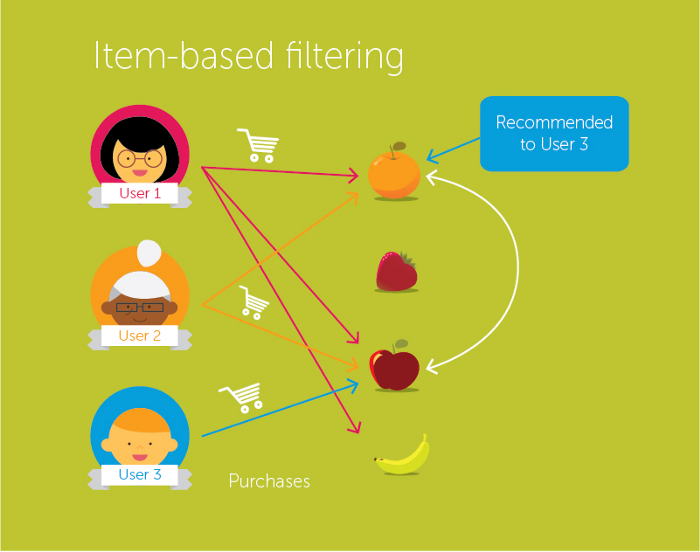

This model is quite similar to the previous model we've used, but instead of focusing on the similarity between users we turn our attention to the similarity between items (in this case the items are movies). The basic idea behind this model is that if user i liked movie m and move z is similar to movie m then user i should like that movie as well. 

Just like before we'll start off by creating a similarity matrix (this time between movies) and then use the below formula to predict the ratings a user would assign a given movie. 

This time we will be using movie n's similarity scores with the movie in question as well as the ratings that user u gave those movies in order to predict a rating.

The formula: 

$$\hat{R_{um}} = \frac{\sum_{n=1}^C R_{un} \cdot \text{item_similarity}(m, n)}{\sum_{n=1}^C \text{item_similarity(m, n)}}$$

### Building the Model  

In [723]:
#Using the same df from earlier in the notebook 
ratings_df_user_predictions

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [724]:
#Take a sample of the data set due to computation limits 
df_sample_item_item = ratings_df_user_predictions.sample(frac=0.1, random_state = 1)
df_sample_item_item

,userId,movieId,rating
32974,225,380,3.0
83568,533,103688,5.0
19537,125,149902,2.0
38287,263,1183,5.0
59543,387,1982,3.0
...,...,...,...
82630,525,317,3.5
48914,317,57669,4.0
88233,570,153,2.5
37244,249,102033,3.5


In [725]:
#Create a train and test set 
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_sample_item_item, test_size=0.2, random_state=1)

In [726]:
#Create a matrix contain the movieId, userId, and ratings 
train_matrix_sample_item_item = train_data.pivot_table(index='userId', columns='movieId', values='rating')
train_matrix_sample_item_item

movieId,1,2,3,5,6,7,9,10,11,12,...,184253,184257,184471,184721,185435,185585,187593,190207,190209,190221
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [739]:
#Create an empty matrix for movieIds where we will store the similarity scores that we
#calculate into 
movies1 = df_sample_item_item['movieId'].unique()
movies2 = df_sample_item_item['movieId'].unique()
similarity_matrix_sample_item_item = pd.DataFrame(index=movies1, columns=movies2)

In [740]:
#Function that calcualtes the similarity scores between items 
def find_item_similarity(item_1, item_2, train_matrix_sample_item_item):
    
    #List of users and True or false if user reviewed the target movie 
    users_who_reviewed_1st_item = ~train_matrix_sample_item_item.loc[:, item_1].isna()
    users_who_reviewed_2nd_item = ~train_matrix_sample_item_item.loc[:, item_2].isna()

    users_who_reviewed_both_items = users_who_reviewed_1st_item & users_who_reviewed_2nd_item
    
    #List of trues or false beside user name if they watched both movies
    number_of_users = users_who_reviewed_both_items.sum()
    
    if number_of_users == 0:
        return -1
    
    #A list of the ratings given to item 1 by users who have also watched item 2
    ratings_of_item1 = train_matrix_sample_item_item.loc[users_who_reviewed_both_items, item_1].values.reshape(1,-1)
    #A list of the ratings given to item 2 by users who have also watched item 1
    ratings_of_item2 = train_matrix_sample_item_item.loc[users_who_reviewed_both_items, item_2].values.reshape(1, -1)

    #Now we calculate a similarity score between both items
    #Just need up to here for a similarity matrix 
    similarity = cosine_similarity(ratings_of_item1, ratings_of_item2)[0][0]
    
    return similarity

In [741]:
#Calculating the similarity scores and placing them in the matrix 
import time
start = time.time()

for i in similarity_matrix_sample_item_item:
    for j in similarity_matrix_sample_item_item:
        if j not in train_matrix_sample_item_item.columns or i not in train_matrix_sample_item_item.columns:
            continue
        
        similarity = find_item_similarity(i, j, train_matrix_sample_item_item)
                                                                          
        # If similarity is -1, users have not rated the same movie, so skip
        if similarity == -1: 
            continue
    
        similarity_matrix_sample_item_item[i][j] = similarity
        

similarity_matrix_sample_item_item

end = time.time()
print(end - start)

15749.128868818283


In [742]:
#Due to the large run-time of creating this matrix
#saving the matrix makes sense
%store similarity_matrix_sample_item_item

Stored 'similarity_matrix_sample_item_item' (DataFrame)


In [743]:
similarity_matrix_sample_item_item

,380,103688,149902,1183,1982,552,3446,153,54001,2289,...,82242,5589,5065,2511,91128,3742,3524,107702,4713,102033
380,1,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103688,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149902,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
3524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
4713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [745]:
#Making Predictions 
movie_predictions = []

for row in test_data.itertuples():
    movieId = row.movieId
    userId = row.userId
    
    # if movieId doesn't exist in train_data we can't make a prediction
    if movieId not in train_matrix_sample_item_item.columns:
        movie_predictions.append(-1)
        continue
    
    if userId not in train_matrix_sample_item_item.index:
        movie_predictions.append(-1)
        continue
    
    # fetch movie ratings for given movieId and filter out NaNs
    R_df3 = train_matrix_sample_item_item.loc[:,~train_matrix_sample_item_item.loc[userId,:].isna()].copy()
    movie_ratings = []
    movie_similarities = []
    for movie in R_df3.columns:
        if movie == 0 or movieId == 0:
            continue
        similarity = similarity_matrix_sample_item_item.loc[movieId, movie]
        user_movie_rating = train_matrix_sample_item_item.loc[userId, movie]
        

        if np.isnan(similarity) or np.isnan(user_movie_rating):
            continue
        
        
        movie_similarities.append(similarity)
        movie_ratings.append(user_movie_rating)
     
    if len(movie_similarities) == 0:
        movie_predictions.append(-1)
        continue
        
    predicted_rating = np.dot(movie_ratings, movie_similarities)/np.sum(movie_similarities)
    movie_predictions.append(predicted_rating)    

In [750]:
#Creating a table with both the actual ratings and the predictions from item-item 
test_data_predictions_unfiltered_item_item = test_data.copy()
test_data_predictions_unfiltered_item_item['item_item_predictions'] = movie_predictions
test_data_predictions_unfiltered_item_item

,userId,movieId,rating,item_item_predictions
23571,160,3256,1.0,2.000000
82997,525,69122,3.0,3.812500
66081,425,3114,3.0,3.500000
20247,132,46578,4.0,4.000000
26730,182,4008,4.0,-1.000000
...,...,...,...,...
24258,168,1219,4.0,4.500000
32178,220,5378,4.0,3.998627
67721,438,1675,3.5,-1.000000
13747,89,46105,4.5,-1.000000


In [751]:
#Removing rows where we couldn't predict a rating for the user-movie pairing due to insufficient training data 
test_data_predictions_filtered_item_item = test_data_predictions_unfiltered_item_item[test_data_predictions_unfiltered_item_item.item_item_predictions != -1]
test_data_predictions_filtered_item_item

,userId,movieId,rating,item_item_predictions
23571,160,3256,1.0,2.000000
82997,525,69122,3.0,3.812500
66081,425,3114,3.0,3.500000
20247,132,46578,4.0,4.000000
73433,474,1230,4.0,4.000000
...,...,...,...,...
54764,362,858,5.0,4.374848
19490,125,119141,4.0,4.000000
59729,387,3300,3.5,4.000000
24258,168,1219,4.0,4.500000


### Evaluating the Model 

In [752]:
#Calculating the RMSE for this model
RMSE = sqrt(mean_squared_error(test_data_predictions_filtered_item_item['rating'], test_data_predictions_filtered_item_item['item_item_predictions']))
RMSE

1.079151038334436

In [753]:
#Calculating the MAE for this model
mean_absolute_error(test_data_predictions_filtered_item_item['rating'], test_data_predictions_filtered_item_item['item_item_predictions'])

0.8194914337105602

### Recommendations for User 414 

In [760]:
user14_predictions_item_item = []
userId = 414

for movieId in user414_not_rated_movieId_list:
    
    #if movieId doesn't exist in train_data we can't make a prediction
    if movieId not in train_matrix_sample_item_item.columns:
        user14_predictions_item_item.append(-1)
        continue
    
    # fetch movie ratings for given movieId and filter out NaNs
    R_df3 = train_matrix_sample_item_item.loc[:,~train_matrix_sample_item_item.loc[userId,:].isna()].copy()
    movie_ratings = []
    movie_similarities = []
    for movie in R_df3.columns:
        if movie == 0 or movieId == 0:
            continue
        similarity = similarity_matrix_sample_item_item.loc[movieId, movie]
        user_movie_rating = train_matrix_sample_item_item.loc[userId, movie]
        

        if np.isnan(similarity) or np.isnan(user_movie_rating):
            continue
        
        
        movie_similarities.append(similarity)
        movie_ratings.append(user_movie_rating)
     
    if len(movie_similarities) == 0:
        user14_predictions_item_item.append(-1)
        continue
        
    predicted_rating = np.dot(movie_ratings, movie_similarities)/np.sum(movie_similarities)
    user14_predictions_item_item.append(predicted_rating)    

In [761]:
#Creating the list of top movie recommendations for this user 
Top_recomm_user414_item_item = pd.DataFrame({'movieId': user414_not_rated_movieId_list, 'predicted_score': user14_predictions_item_item}, columns=['movieId', 'predicted_score'])
Top_recomm_user414_item_item = Top_recomm_user414_item_item.sort_values(by=['predicted_score'],ascending=False)

#Removing predictions for movies we couldn't predict a rating for due to insufficient data 
Top_recomm_user414_item_item = Top_recomm_user414_item_item[Top_recomm_user414_item_item.predicted_score != -1]


Top_recomm_user414_item_item

,movieId,predicted_score
4438,63436,5.0
411,1041,5.0
369,938,5.0
450,1150,5.0
2199,5404,5.0
...,...,...
1637,3840,2.0
4937,82242,2.0
3966,45431,1.5
6254,135436,1.5


In [763]:
#Adding the title of each movie to the df
Top_recomm_user414_item_item = Top_recomm_user414_item_item.merge(titles_ratings_df[['title', 'movieId']], on='movieId', how='left')
Top_recomm_user414_item_item = Top_recomm_user414_item_item.drop_duplicates(subset='title')
Top_recomm_user414_item_item.head(10)

,movieId,predicted_score,title
0,63436,5.0,Saw V (2008)
3,1041,5.0,Secrets & Lies (1996)
14,938,5.0,Gigi (1958)
20,1150,5.0,"Return of Martin Guerre, The (Retour de Martin..."
23,5404,5.0,84 Charing Cross Road (1987)
26,56949,5.0,27 Dresses (2008)
46,1762,5.0,Deep Rising (1998)
51,3097,5.0,"Shop Around the Corner, The (1940)"
54,4792,5.0,13 Ghosts (1960)
58,1019,5.0,"20,000 Leagues Under the Sea (1954)"


In [764]:
#Adjusting the titles based on vote count 

#Add number of votes to each row 
Top_recomm_user414_item_item = Top_recomm_user414_item_item.merge(number_of_times_rated[['title', 'times_rated']], on='title', how='left')
Top_recomm_user414_item_item.head(25)

#Based on the output we can see that many of the top recommendations come from movies that have only been rated once

,movieId,predicted_score,title,times_rated
0,63436,5.0,Saw V (2008),3
1,1041,5.0,Secrets & Lies (1996),11
2,938,5.0,Gigi (1958),6
3,1150,5.0,"Return of Martin Guerre, The (Retour de Martin...",3
4,5404,5.0,84 Charing Cross Road (1987),3
5,56949,5.0,27 Dresses (2008),20
6,1762,5.0,Deep Rising (1998),5
7,3097,5.0,"Shop Around the Corner, The (1940)",3
8,4792,5.0,13 Ghosts (1960),4
9,1019,5.0,"20,000 Leagues Under the Sea (1954)",17


In [766]:
#Filter for a cutoff 
Top_recomm_user414_item_item = Top_recomm_user414_item_item[Top_recomm_user414_item_item['times_rated'] > 20]
Top_recomm_user414_item_item.head(3)

#Different results than the last model 
#Based on the dates of the top 3 movies, user414 seems to be a fan of older movies 

,movieId,predicted_score,title,times_rated
16,1253,4.5,"Day the Earth Stood Still, The (1951)",25
21,1244,4.5,Manhattan (1979),33
32,98809,4.5,"Hobbit: An Unexpected Journey, The (2012)",40


### Funk Singular Value Decompisition (Funk SVD)

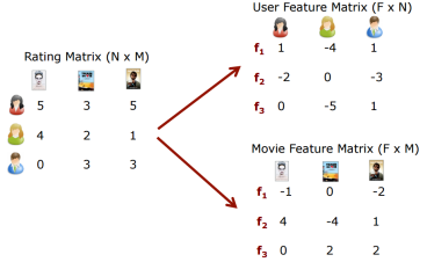

The final model I'll be using for this project is based on **matrix factorization**. 
In this case, we'll be using matrix factorization to learn the 'latent (i.e. hidden) preferences' of users and the 'latent attributes' of movies from known ratings and then use these latent preferences/attributes to predict the ratings users would give to movies they have yet to rate. 

Without getting too deep into the math behind this model, what the picture just above shows is that by doing matrix factorization, we can restructure the User-Item Matrix that we've been using in the previous two models into two separate user and movie matrices. These two matrices contain the latent variables for each user and each item respectivaly. 


In [390]:
from surprise import Dataset
from surprise.reader import Reader
import csv
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import accuracy
from surprise.model_selection import train_test_split

In [368]:
#The surprise package requires that the dataset be in the format of userid-movieid-ratings
ratings_df_FunkSVD = ratings_df.drop('timestamp', axis=1)
ratings_df_FunkSVD

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [382]:
#Loading my data set
data = Dataset.load_from_df(ratings_df_FunkSVD, Reader(rating_scale=(0.5, 5)))
raw_ratings = data.raw_ratings

In [385]:
#shuffling the ratings 
import random
random.shuffle(raw_ratings)

In [386]:
# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [387]:
#data is now the set A
data.raw_ratings = A_raw_ratings  

In [391]:
#Select your best algo with grid search.
print('Grid Search...')
param_grid = {'n_factors':[10,15],'n_epochs':[50,100,150],'lr_all':[0.01,.1],'reg_all':[0.02,0.1]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

Grid Search...


In [392]:
algo = grid_search.best_estimator['rmse']

In [393]:
#retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

### Model Evaluation

In [394]:
#Compute biased accuracy on train set
predictions = algo.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictions)

Biased accuracy on A,   RMSE: 0.6696


0.669636613210003

In [395]:
#Compute unbiased accuracy on test set
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictions)

Unbiased accuracy on B, RMSE: 0.8394


0.8394487786483218

In [397]:
#MAE - the lower the better 
MAE = accuracy.mae(predictions, verbose=False)
print(MAE)

0.6442830839060494


### Recommendations for User 414

In [399]:
#Function to retrieve the top N recommendations for users 
from collections import defaultdict

def get_top_n(recommendations, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Then sort the predictions for each user and retrieve the n highest ones    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [400]:
#Defining the variable
top_n = get_top_n(predictions, n=10)

In [401]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

131 [1276, 1228, 608, 7361, 4226, 1214, 47, 79132, 2273]
561 [7153, 1197, 1213, 1270, 6377, 79132, 2997, 1278, 457, 2194]
228 [318, 362, 1214, 1385]
607 [3147, 2028, 1258, 1356, 593, 919, 1079, 1625, 1240, 3105]
153 [3949, 158966, 1246, 1206, 8784, 6377, 1193, 2858, 177615, 55269]
580 [7371, 2360, 32, 2329, 1089, 2788, 1222, 32587, 33493, 5418]
371 [56715, 55167, 741, 81834, 3793, 2140, 1748, 2987, 661]
605 [260, 1210, 7153, 27251, 69844, 33794, 919, 3052, 3742, 55872]
600 [2959, 2502, 1, 1274, 27879, 1073, 1617, 1036, 26712, 3504]
166 [4973, 1276, 1198, 1617, 2028, 46578, 49272, 6, 5989, 2115]
351 [60069, 4226, 89774, 8914, 83134, 88744, 7254, 6379, 54787, 43836]
57 [1208, 1270, 922, 541, 908, 1079, 899, 2529, 942, 2921]
18 [904, 1276, 1213, 527, 1193, 4226, 6300, 2692, 541, 73323]
271 [969, 345, 1994, 1909, 1047, 2641, 1371]
29 [1204, 1272, 1945, 1250, 1209, 2028, 1198, 1201, 914, 3681]
167 [6283, 40815, 4963, 6773, 7147, 2231, 4678, 5464, 3793, 2657]
356 [1222, 5618, 356, 56715, 114

In [404]:
#Based on the above output the recommendations for user 414 are stored in the list below:
user414_top10 = [1178, 4334, 1204, 1594, 1225, 4389, 162, 44761, 3037, 475]

In [407]:
#Getting the name of the top 10 recommended movies
top_10_movies = []
for i in user414_top10:
    movie_name_in_a_list = titles_ratings_df.loc[titles_ratings_df['movieId'] == i]
    top_10_movies.append(movie_name_in_a_list['title'].iloc[0])

top_10_movies 

['Paths of Glory (1957)',
 'Yi Yi (2000)',
 'Lawrence of Arabia (1962)',
 'In the Company of Men (1997)',
 'Amadeus (1984)',
 'Lost and Delirious (2001)',
 'Crumb (1994)',
 'Brick (2005)',
 'Little Big Man (1970)',
 'In the Name of the Father (1993)']

In [748]:
#Putting the names in a nicer looking table 
top_10_movies_SVD = pd.DataFrame(top_10_movies,columns=['Top 10 Recommendations'])
top_10_movies_SVD 

,Top 10 Recommendations
0,Paths of Glory (1957)
1,Yi Yi (2000)
2,Lawrence of Arabia (1962)
3,In the Company of Men (1997)
4,Amadeus (1984)
5,Lost and Delirious (2001)
6,Crumb (1994)
7,Brick (2005)
8,Little Big Man (1970)
9,In the Name of the Father (1993)


## Conclusion

In evaluating the collaborative filtering models there were two things I considered. First, was the accuracy of each model, which I evaluated using the RMSE and MAE. Based on those results, the SVD based version was the most accurate. The second consideration was run-time, which is vital to consider since streaming platforms have customers that expect to receive new recommendations on a daily basis. While it took the first two variations several days to run (when using the entire data set), the SVD based version only took 20 minutes! 

Based on the results of each model with regards to their accuracy and run-time, the SVD based model is the most viable option to build a complete recommendation system around. However, based on my initial goal of building a model on top of which I could create a fully functional recommendation system, my SVD model’s accuracy score wasn’t nearly high enough. 

## Next Steps

My overall objective continues to be to build a recommendation system that meets the needs of stakeholders within the streaming industry better than systems currently being used today. However, the model I hoped to build my system around wasn’t as accurate as I’d hoped and thus my next step will be to improve my model’s accuracy by investigating model’s that take advantage of deep learning techniques and to then incorporate those models along with my SVD based model with the intention of building a finalized hybrid model that produces significantly higher accuracy scores. Once that is done, I’ll continue to build my recommendation system by implementing solutions that assist in making recommendations where my model fails (such as instances where new users who we do not have information about join the platform) as well as continuing to tune how the model works. Eventually, I would like to launch my finalized system online and allow users to sign up and receive recommendations. Based on user feedback and I will continue to adjust the recommendation system until it is capable of filling that industry sweet spot . 
